# HITL (Human in the Loop)

In [1]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

2025-12-11 19:35:23.243096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Importer le modèle pré-entraîné de Artifact Registry Google with bentoml

# dvc pull (dossier model)
# bentoml models import /home/cris/mlops/MLOps-project/model/trash_classifier_model.bentomodel
# mettre le chemin absolu du fichier .bentomodel

# Référence au modèle entrainé : tag="trash_classifier_model:ciqmwpguswhiypxm" 
# mobilnet 9 epochs

import bentoml
from bentoml.models import BentoModel
from bentoml.keras import load_model

# Récupérer la dernière version du modèle importé
model_ref = bentoml.models.get("trash_classifier_model:latest")
print(model_ref)

# Charger le modèle
model = load_model(model_ref)

/tmp/ipykernel_68850/133725877.py:9: BentoMLDeprecationWarning: `bentoml.keras` is deprecated since BentoML v1.4 and will be removed in a future version.
  from bentoml.keras import load_model


Model(tag="trash_classifier_model:ciqmwpguswhiypxm")


I0000 00:00:1765481597.165687   68850 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [33]:
# Import Dataset

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

ds = tf.keras.utils.image_dataset_from_directory(
    "../data/raw2/train/images/.",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    verbose=1,
)


Found 7324 files.


2025-12-11 20:53:25.978545: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


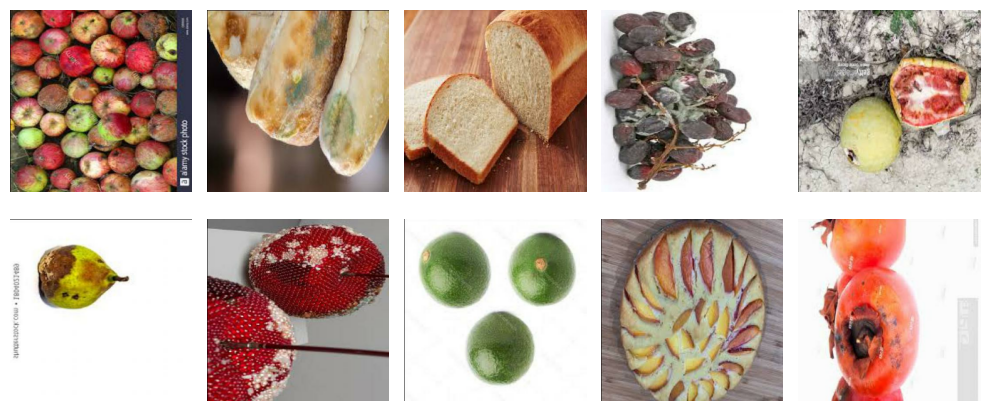

In [34]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images in ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [35]:
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds = ds.map(lambda x: normalization_layer(x))

In [36]:
preds= model.predict(ds)

2025-12-11 20:54:55.475404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


229/229 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step


In [37]:
probs = tf.nn.softmax(preds, axis=-1).numpy() # # (N, num_classes)

In [ ]:
y_pred = np.argmax(probs, axis=-1) # (N,)

In [45]:
# Labels:
#    0: cardboard
#    1: glass
#    2: metal
#    3: paper
#    4: plastic
#    5: trash

def transform_labels_to_int(label : str) -> int:
    match label:
        case 'cardboard':
            return 0
        case 'glass':
            return 1
        case 'metal':
            return 2
        case 'paper':
            return 3
        case 'plastic':
            return 4
        case 'trash':
            return 5

In [46]:
data_dir = './../data/raw2/train/images/'
classes = ['biodegradable', 'cardboard', 'glass', 'metal', 'paper', 'plastic']

import re
def natural_key(path):
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', path.name)]

data_dir = Path("../data/raw2/train/images")
file_paths = sorted(data_dir.iterdir(), key=natural_key)
noms = [p.name for p in file_paths]

In [55]:
# si la probabilité maximale est inférieure à un seuil, alors on considère que le modèle n'est pas sûr de sa prédiction
threshold = 0.7


uncertain_indices = [i for i, p in enumerate(probs) if np.max(p) < threshold]
print("Indices des images incertaines :", uncertain_indices)

# placer dans un dossier "uncertain_images" les images correspondantes aux indices incertains
import shutil
uncertain_dir = Path("../data/uncertain_images")
uncertain_dir.mkdir(parents=True, exist_ok=True)        
for i in uncertain_indices:
    src = Path(data_dir) / noms[i]
    dst = uncertain_dir / noms[i]
    shutil.copy(src, dst)
print(f"Images incertaines copiées dans le dossier {uncertain_dir}")
print("Prédictions :", y_pred)

Indices des images incertaines : [18, 44, 122, 232, 239, 252, 253, 259, 298, 343, 352, 438, 512, 562, 577, 592, 604, 605, 649, 691, 729, 773, 822, 841, 856, 859, 880, 889, 925, 948, 982, 998, 1006, 1052, 1096, 1192, 1229, 1236, 1296, 1330, 1370, 1378, 1415, 1427, 1431, 1437, 1456, 1457, 1461, 1489, 1516, 1522, 1545, 1552, 1576, 1603, 1608, 1629, 1635, 1679, 1716, 1743, 1759, 1763, 1773, 1782, 1785, 1787, 1816, 1820, 1874, 1883, 1885, 1895, 1899, 1919, 1940, 1952, 1969, 1972, 1977, 1978, 1983, 1985, 2027, 2047, 2065, 2139, 2161, 2179, 2192, 2199, 2203, 2209, 2224, 2232, 2239, 2243, 2255, 2259, 2271, 2321, 2322, 2330, 2332, 2342, 2378, 2384, 2405, 2414, 2427, 2454, 2467, 2483, 2487, 2488, 2498, 2502, 2507, 2511, 2514, 2515, 2526, 2533, 2536, 2542, 2543, 2549, 2552, 2558, 2560, 2568, 2571, 2572, 2576, 2592, 2605, 2609, 2621, 2623, 2629, 2633, 2653, 2673, 2679, 2686, 2689, 2697, 2727, 2739, 2770, 2777, 2798, 2799, 2834, 2838, 2856, 2867, 2870, 2872, 2874, 2883, 2886, 2895, 2897, 2900, 2919

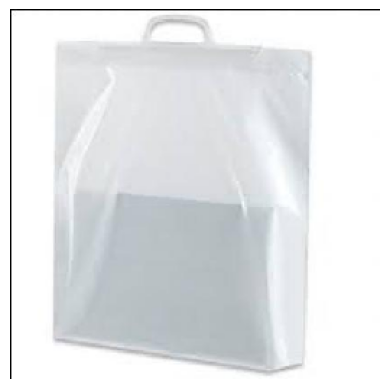

In [52]:
# Afficher image dans uncertain_images
img_path = uncertain_dir / noms[uncertain_indices[697]]
img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
plt.imshow(img)
plt.axis("off")
plt.show()